In [1]:
# Importing necessary Libraries

In [2]:
#Importing necessary Libraries;
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14,6)
from matplotlib.colors import ListedColormap
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn import linear_model
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as  metrics
from IPython.display import display
from sklearn.cross_validation import train_test_split
#from sklearn.cross_validation import  cross_val_score
from sklearn.model_selection import  cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import tree
from sklearn import naive_bayes
from sklearn.learning_curve import learning_curve
from sklearn import cross_validation
from sklearn.metrics import  make_scorer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
sns.set(style="darkgrid")
import os
from sklearn import cross_validation

Populating the interactive namespace from numpy and matplotlib


C:\Users\Krishna\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Krishna\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\Krishna\Anaconda2\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarn

In [3]:
import pandas as pd
import datetime
import time
from datetime import date
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd
from docx import Document
import nltk
import textblob
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.svm import SVC

### Creating Technical Dataset

In [5]:
spy = pd.read_csv("SPY.csv")

In [6]:
sp = spy[:309]

In [7]:
sp = sp[["Date","Close","Volume"]]

### Creating additional technical variables

In [8]:
# Creating Momentum variable as Mmtm
sp["Mmtm"] = (sp["Close"]-sp["Close"].shift()) * sp["Volume"]

In [9]:
sp["Log_change"] = np.log(sp.Close) - np.log(sp.Close.shift(1))
sp["3sma"] = pd.rolling_mean(sp["Close"],3)
sp["7sma"] = pd.rolling_mean(sp["Close"],7)
sp["12sma"] = pd.rolling_mean(sp["Close"],12)

C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
  
C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.


In [10]:
# Creating SP500/90 day MVA variable
sp["SP500/90MVA"] = sp["Close"]/sp["3sma"]

In [11]:
sp1 = sp.drop("Volume",1)

In [12]:
sp1 = sp1.fillna(0)

In [13]:
sp1.head()

,Date,Close,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA
0,1990-01-01,329.079987,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000
1,1990-02-01,331.890015,8.323219e+09,0.008503,0.000000,0.0,0.0,0.000000
2,1990-03-01,339.940002,2.643036e+10,0.023966,333.636668,0.0,0.0,1.018893
3,1990-04-01,330.799988,-2.560319e+10,-0.027255,334.210002,0.0,0.0,0.989797
4,1990-05-01,361.230011,1.094471e+11,0.088001,343.990000,0.0,0.0,1.050118


### Preparing fundamental Dataset

In [14]:
fund = pd.read_csv("f1.csv")
tentsy = pd.read_csv("10 tsy.csv")
fivetsy = pd.read_csv("5 tsy.csv")
twotsy = pd.read_csv("2 tsy.csv")

In [15]:
#dvrate = Annualized dividend rate
#EPS = Earnings per Share
#Prcrcm =  Closing Price
#10 Tsy = 10 year treasury rate
#5 Tsy = 5 year treasury rate
#2 Tsy = 2 year treasury rate

In [16]:
fund = fund[["dvrate","epsx12","prccm","datadate"]]
fund["PE"] = fund["prccm"]/fund["epsx12"]
fund = fund[["dvrate","datadate","PE"]]
fund["Date"] = fund['datadate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
fund = fund[["dvrate","PE"]]

In [17]:
TT = tentsy.reindex(index=tentsy.index[::-1])
FT = fivetsy.reindex(index=fivetsy.index[::-1])
TwT = twotsy.reindex(index=twotsy.index[::-1])

In [18]:
fnd = fund.copy()
fnd["10 tsy"] = TT["Price"]
fnd["5 tsy"] = FT["Price"]
fnd["2 tsy"] = TwT["Price"]

### Creating Sentimental Dataset

In [19]:
year = range(1990,2016)

In [20]:
yr = dict.fromkeys(year)

In [21]:
for key in yr.keys():
    f = Document(str(key)+".docx")
    yr[key] = []
    p = []
    s = []
    for para in f.paragraphs:
        an= textblob.TextBlob(para.text)
        sn = an.sentiment
        p.append(sn.polarity)
        s.append(sn.subjectivity)
    yr[key]= [sum(p)/len(p), sum(s)/len(s)]

In [22]:
sent = pd.DataFrame(yr.values())
sent.columns = ["Pol", "Sub"]

In [23]:
pol = sent["Pol"]
pol1 = np.repeat(pol,12)
sub = sent["Sub"]
sub1 = np.repeat(sub,12)
snt = pd.DataFrame()
snt["Pol"] = pol1
snt["Sub"] = sub1
snt =  snt[:309]

In [24]:
snt = snt.reset_index()
snt = snt[["Pol","Sub"]]

### Creating Final Dataset

In [43]:
df = sp1.copy()
f2 = fnd.copy()
s2 = snt.copy()

In [44]:
df = df.join(f2)
df = df.join(s2) #DF is the final dataset

In [45]:
df["Pred"] = np.where(df["Close"]>df["Close"].shift(),1,0)

In [46]:
df.head()

,Date,Close,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA,dvrate,PE,10 tsy,5 tsy,2 tsy,Pol,Sub,Pred
0,1990-01-01,329.079987,0.000000e+00,0.000000,0.000000,0.0,0.0,0.000000,11.40,14.389777,2.269,1.766,1.064,0.03096,0.281961,0
1,1990-02-01,331.890015,8.323219e+09,0.008503,0.000000,0.0,0.0,0.000000,11.40,14.512655,2.208,1.654,0.934,0.03096,0.281961,1
2,1990-03-01,339.940002,2.643036e+10,0.023966,333.636668,0.0,0.0,1.018893,11.04,15.687120,2.146,1.528,0.736,0.03096,0.281961,1
3,1990-04-01,330.799988,-2.560319e+10,-0.027255,334.210002,0.0,0.0,0.989797,11.04,15.265335,2.035,1.375,0.645,0.03096,0.281961,0
4,1990-05-01,361.230011,1.094471e+11,0.088001,343.990000,0.0,0.0,1.050118,11.04,16.669589,2.214,1.541,0.739,0.03096,0.281961,1


### Data Manipulation

In [47]:
# Our goal is to predict the movement of the S&P 500 using the previous months data
# For example, We have to predict the Febraury movement using the January Data
# So Our target variable is 1 step ahead of the X-Variables
# To Compensate we shift our target variable one step back wards

In [48]:
df["Pred"] = df["Pred"].shift(-1)
df = df.fillna(0)

### Creating Final Feature and Prediction variable Datasets

In [57]:
#Dataset of Dates
df_date = df["Date"]

In [58]:
# Dataset Of X-Variables
df_x = df[["Mmtm","Log_change","3sma","7sma","12sma","SP500/90MVA","dvrate","PE","10 tsy","5 tsy","2 tsy","Pol","Pred"]]

In [60]:
#Dataset Of Y-variables
df_y = df["Pred"]

### Normalizing Data

In [61]:
#This data is Panel data.So, the terms like Close and Volume will consistetly increase with time.
#So it doesn't make any sense to Normalize the data
#So instead we take the Log differntiation for some Momentum variable to solve this.
# We are doing this only for momentum variable because they differ from other variables by a very large margin

In [62]:
df_x["Mmtm"] = np.log(df_x.Mmtm) - np.log(df_x.Mmtm.shift(1))

C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
df_x = df_x.replace(np.inf, np.nan)
df_x=df_x.fillna(0)

In [64]:
# Our final set of X-Variables
df_x.head()

,Mmtm,Log_change,3sma,7sma,12sma,SP500/90MVA,dvrate,PE,10 tsy,5 tsy,2 tsy,Pol,Pred
0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,11.40,14.389777,2.269,1.766,1.064,0.03096,1.0
1,0.000000,0.008503,0.000000,0.0,0.0,0.000000,11.40,14.512655,2.208,1.654,0.934,0.03096,1.0
2,1.155464,0.023966,333.636668,0.0,0.0,1.018893,11.04,15.687120,2.146,1.528,0.736,0.03096,0.0
3,0.000000,-0.027255,334.210002,0.0,0.0,0.989797,11.04,15.265335,2.035,1.375,0.645,0.03096,1.0
4,0.000000,0.088001,343.990000,0.0,0.0,1.050118,11.04,16.669589,2.214,1.541,0.739,0.03096,0.0


### Building our Models

In [65]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

In [66]:
def roc_curve(y_test,y_predicted_probability,pos_label=None):
    if pos_label==None:
        pos_label=1
    fpr,tpr,thresholds=metrics.roc_curve(y_test,y_predicted_probability,pos_label=pos_label )
    plt.plot(fpr,tpr)
    plt.xlabel("False Positive rate")
    plt.ylabel("True Positive rate")
    plt.title("ROC Curve")
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.grid(True)
    print "AUC of the model is {:.10f}".format(metrics.roc_auc_score(y_test,y_predicted_probability))
    plt.show()

#### Logistic Regression Model

In [76]:
lgtr = linear_model.LogisticRegression(penalty= "l1")

In [77]:
lgtr = lgtr.fit(X_train,y_train)

In [78]:
y_predlrm = lgtr.predict(X_test)

In [79]:
print "Accuracy: ",accuracy_score(y_test, y_predlrm)
print "Precision: ",precision_score(y_test, y_predlrm)
print "Recall: ",recall_score(y_test, y_predlrm)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


AUC of the model is 1.0000000000


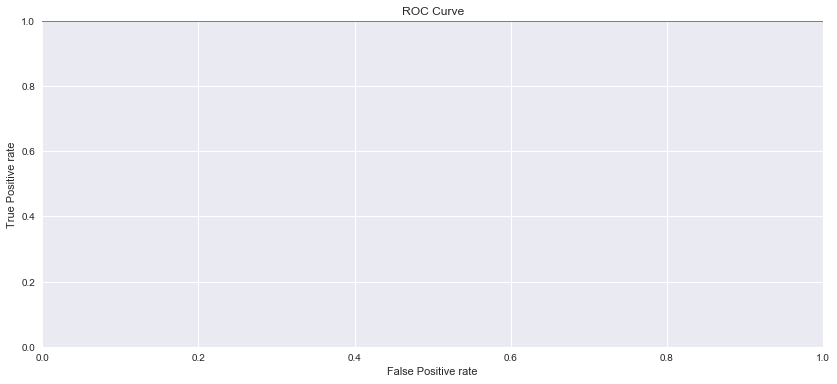

In [80]:
roc_curve(y_test,y_predlrm,pos_label=None)

#### SVM Model

In [81]:
# Creating a Model using Polynomial kernel
psvm = svm.SVC(kernel= "poly")

In [82]:
psvm.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [83]:
y_predpsvm = psvm.predict(X_test)

In [84]:
print "Accuracy: ",accuracy_score(y_test, y_predpsvm)
print "Precision: ",precision_score(y_test, y_predpsvm)
print "Recall: ",recall_score(y_test, y_predpsvm)

Accuracy:  0.978494623656
Precision:  0.981132075472
Recall:  0.981132075472


AUC of the model is 0.9780660377


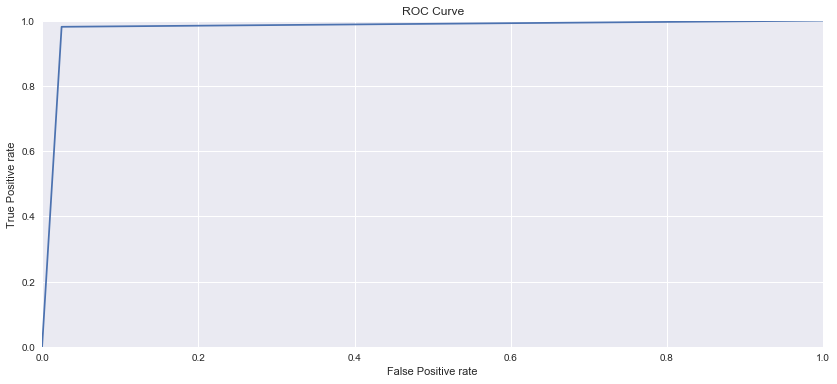

In [85]:
roc_curve(y_test,y_predpsvm,pos_label=None)

#### Random Forest Model

In [86]:
rfr = RandomForestClassifier(n_estimators = 100, oob_score =  True, random_state = 42)

In [87]:
rfr = rfr.fit(X_train,y_train)

In [88]:
y_predrfr = rfr.predict(X_test)

In [89]:
print "Accuracy: ",accuracy_score(y_test, y_predrfr)
print "Precision: ",precision_score(y_test, y_predrfr)
print "Recall: ",recall_score(y_test, y_predrfr)

Accuracy:  1.0
Precision:  1.0
Recall:  1.0


AUC of the model is 1.0000000000


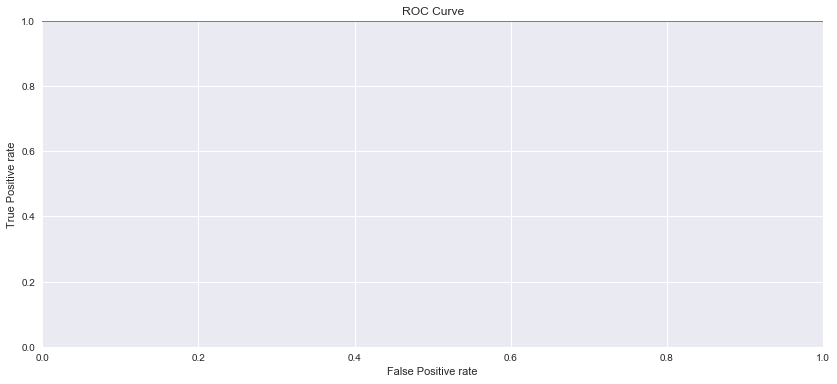

In [90]:
roc_curve(y_test,y_predrfr,pos_label=None)

#### Neural Network Model

In [91]:
nnm = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(66,33,10,1), max_iter =1000000,batch_size=2000)

In [92]:
nnm = nnm.fit(X_train.as_matrix().astype(np.float), y_train.values.ravel())

In [93]:
y_prednnm = nnm.predict(X_test)

In [94]:
print "Accuracy: ",accuracy_score(y_test, y_prednnm)
print "Precision: ",precision_score(y_test, y_prednnm)
print "Recall: ",recall_score(y_test, y_prednnm)

Accuracy:  0.569892473118
Precision:  0.569892473118
Recall:  1.0


AUC of the model is 0.5000000000


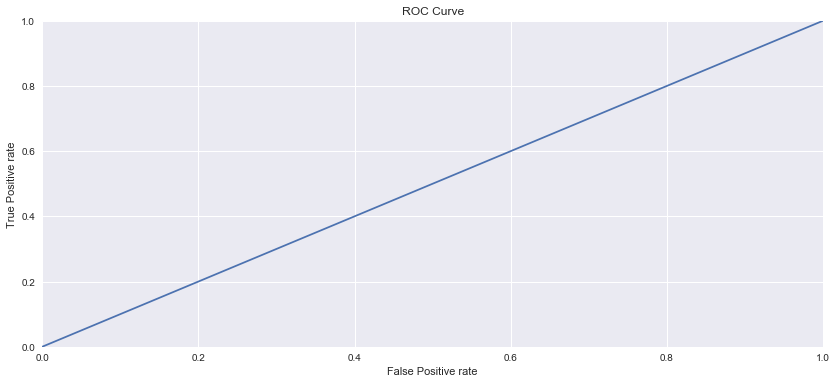

In [95]:
roc_curve(y_test,y_prednnm,pos_label=None)

### Building Models with Cross Validation

In [72]:
models = []
models.append(('LR', LogisticRegression(penalty= "l1")))
models.append(('RF', RandomForestClassifier(n_estimators = 100, oob_score =  True, random_state = 42)))
models.append(('SVM', SVC(kernel= "poly")))
models.append(('MLP', MLPClassifier(solver='lbfgs',hidden_layer_sizes=(66,33,10,1), max_iter =1000000,batch_size=2000)))
#Evaluate each model
#K-fold for more accuracy (but slow; all the data is used for testing and training)
results = []
names = []

In [73]:
for name, model in models:
    kfold = KFold(n_splits = 10, random_state = seed)
    cv_results = cross_val_score(model, df_x, df_y, cv = kfold, scoring = "precision")
    cv_results1 = cross_val_score(model, df_x, df_y, cv = kfold, scoring = "recall")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f %f" % (name, cv_results.mean(), cv_results1.mean())
    print(msg)

LR: 1.000000 0.955556
RF: 1.000000 1.000000
SVM: 0.949511 0.898333
MLP: 0.634633 1.000000


### Evaluating performance of each model with $1,00,000 investment

In [96]:
# roe is a function which shows the value of investment over 25 years
def roe(model):
    spy = sp[:310]
    spy1 = spy[["Date","Close"]]
    spy1["PctChange"] = spy1["Close"].pct_change()
    spy1 = spy1.fillna(0)
    pc = spy1["PctChange"]
    spy = spy1["PctChange"]
    pred = model.predict(df_x)
    spy1["pred"] = pred
    pred1 = np.where(pred>0.0,1,-1)
    spy1["pred1"] = pred1
    pct1 = pred1 * pc
    spy1["pct1"] = pct1
    pct2 = pct1 + 1.0
    spy1["pct2"] = pct2
    pctc = np.cumprod(pct2)
    spy1["pctc"] = pctc
    inv = 100000.0 * pctc 
    spy1["Inv"] = inv
    return spy1["Inv"]

In [97]:
Ilgtr = roe(lgtr)
Irfr = roe(rfr)
Ipsvm = roe(psvm)
Innm = roe(nnm)

C:\Users\Krishna\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


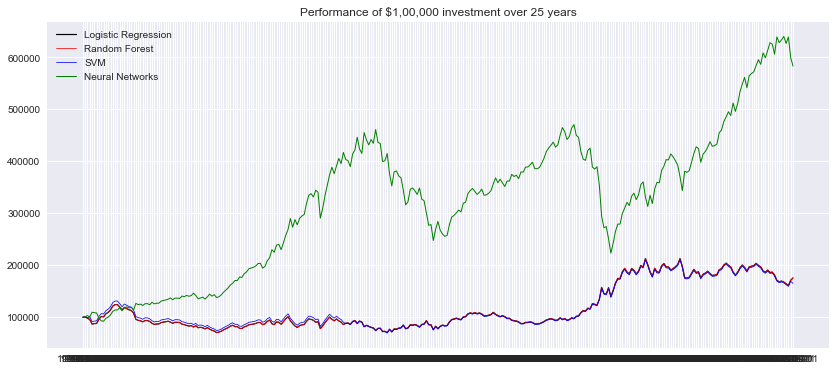

In [98]:
plt.plot(df_date, Ilgtr,label = "Logistic Regression", color = "k", ls = "-", lw = 1.2)
plt.plot(df_date, Irfr,label = "Random Forest", color = "r", ls = "-", lw = 0.75) 
plt.plot(df_date, Ipsvm,label = "SVM", color = "b", ls = "-", lw = 0.75) 
plt.plot(df_date, Innm,label = "Neural Networks", color = "g", ls = "-", lw = 1.0) 
plt.title("Performance of $1,00,000 investment over 25 years")
plt.legend()
plt.show()